## Imports

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import time

In [75]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_aer
!pip install qiskit_algorithms

In [58]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_aer.primitives import SamplerV2
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit import ParameterVector

## Loading Dataset

In [59]:
# Loading Dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [60]:
# Restrict to two classes (binary classification)
mask = y < 2
X = X[mask]
y = y[mask]

In [61]:
# Restrict to two features for 2-qubit encoding
X = X[:, :2]

In [62]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [64]:
print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

Training samples: 70 | Test samples: 30


## Quantum Circuits

In [65]:
def feature_map_simple(num_features: int) -> QuantumCircuit:
    """Parameterized simple feature map
       Simple RY rotation with linear CX entanglement
    """
    x = ParameterVector("x", num_features)
    qc = QuantumCircuit(num_features)
    for i in range(num_features): # single rotation layer
        qc.ry(x[i], i)
    for i in range(num_features - 1): # linear entanglement
        qc.cx(i, i + 1)
    return qc

In [66]:
def feature_map_enhanced(num_features: int) -> QuantumCircuit:
    """Parameterized enhanced feature map
       RX, RY, RZ rotations with full CZ entanglement
    """
    x = ParameterVector("x", num_features)
    qc = QuantumCircuit(num_features)
    for i in range(num_features): # multiple rotation layers
        qc.rx(x[i], i)
        qc.ry(x[i] ** 2, i)
        qc.rz(np.sin(x[i]), i)
    for i in range(num_features): # full entanglement
        for j in range(i + 1, num_features):
            qc.cz(i, j)
    return qc

In [71]:
num_features = X_train.shape[1]

print("Simple feature map:")
print(feature_map_simple(num_features).draw())

print("\nEnhanced feature map:")
print(feature_map_enhanced(num_features).draw())

Simple feature map:
     ┌──────────┐     
q_0: ┤ Ry(x[0]) ├──■──
     ├──────────┤┌─┴─┐
q_1: ┤ Ry(x[1]) ├┤ X ├
     └──────────┘└───┘

Enhanced feature map:
     ┌──────────┐┌─────────────┐┌───────────────┐   
q_0: ┤ Rx(x[0]) ├┤ Ry(x[0]**2) ├┤ Rz(sin(x[0])) ├─■─
     ├──────────┤├─────────────┤├───────────────┤ │ 
q_1: ┤ Rx(x[1]) ├┤ Ry(x[1]**2) ├┤ Rz(sin(x[1])) ├─■─
     └──────────┘└─────────────┘└───────────────┘   


## Training

In [72]:
def run_qsvm(X_train, X_test, y_train, y_test, feature_map_func):
    algorithm_globals.random_seed = 42
    sampler = SamplerV2()
    fidelity = ComputeUncompute(sampler=sampler)

    num_features = X_train.shape[1]
    fm = feature_map_func(num_features)

    qkernel = FidelityQuantumKernel(feature_map=fm, fidelity=fidelity)

    kernel_train = qkernel.evaluate(X_train)
    kernel_test = qkernel.evaluate(X_test, X_train)

    svm = SVC(kernel="precomputed")
    svm.fit(kernel_train, y_train)
    y_pred = svm.predict(kernel_test)

    acc = accuracy_score(y_test, y_pred)
    return acc, y_pred, svm

In [79]:
start_time_simple = time.perf_counter()
acc_simple, y_pred_simple, svm_simple = run_qsvm(
    X_train, X_test, y_train, y_test, feature_map_simple
)
end_time_simple = time.perf_counter()

start_time_enhanced = time.perf_counter()
acc_enhanced, y_pred_enhanced, svm_enhanced = run_qsvm(
    X_train, X_test, y_train, y_test, feature_map_enhanced
)
end_time_enhanced = time.perf_counter()

elapsed_time_simple = end_time_simple - start_time_simple
elapsed_time_enhanced = end_time_enhanced - start_time_enhanced

print(f"Execution time (Simple circuit): {elapsed_time_simple:.4f} seconds")
print(f"Execution time (Enhanced circuit): {elapsed_time_enhanced:.4f} seconds")
print(f"\nAccuracy (Simple circuit):   {acc_simple:.3f}")
print(f"Accuracy (Enhanced circuit): {acc_enhanced:.3f}")

Execution time (Simple circuit): 26.9813 seconds
Execution time (Enhanced circuit): 42.3612 seconds

Accuracy (Simple circuit):   1.000
Accuracy (Enhanced circuit): 1.000


## Confusion Matrix

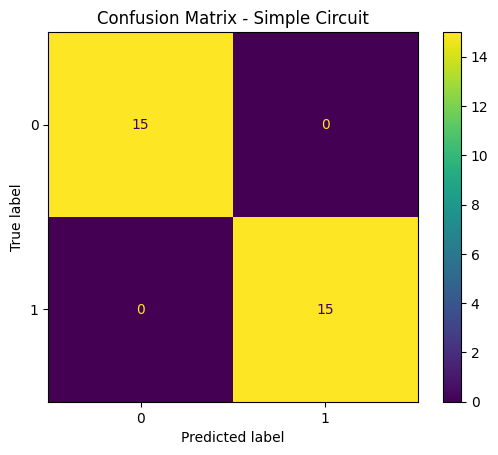

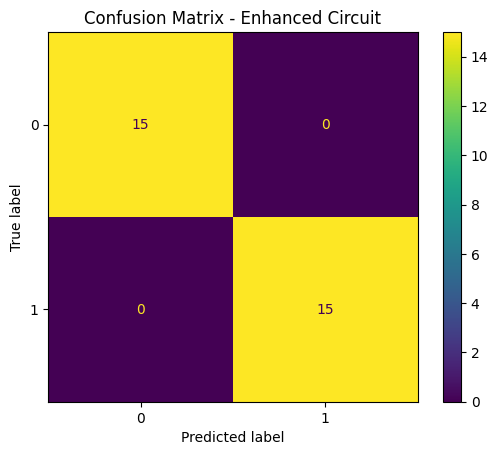

In [74]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simple)
plt.title("Confusion Matrix - Simple Circuit")
plt.show()

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_enhanced)
plt.title("Confusion Matrix - Enhanced Circuit")
plt.show()